# Build a SQL agent

In this tutorial, we will walk through how to build an agent that can answer questions about a SQL database.

At a high level, the agent will:

1. Fetch the available tables from the database
2. Decide which tables are relevant to the question
3. Fetch the schemas for the relevant tables
4. Generate a query based on the question and information from the schemas
5. Double-check the query for common mistakes using an LLM
6. Execute the query and return the results
7. Correct mistakes surfaced by the database engine until the query is successful
8. Formulate a response based on the results

!!! warning "Security note"

    Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your agent's needs. This will mitigate though not eliminate the risks of building a model-driven system.

## 1. Setup

Let's first install some dependencies. This tutorial uses SQL database and tool abstractions from [langchain-community](https://python.langchain.com/docs/concepts/architecture/#langchain-community). We will also require a LangChain [chat model](https://python.langchain.com/docs/concepts/chat_models/).

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_community "langchain[openai]"

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

### Select a LLM

First we [initialize our LLM](https://python.langchain.com/docs/how_to/chat_models_universal_init/). Any model supporting [tool-calling](https://python.langchain.com/docs/integrations/chat/#featured-providers) should work. We use OpenAI below.

In [1]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

### Configure the database

We will be creating a SQLite database for this tutorial. SQLite is a lightweight database that is easy to set up and use. We will be loading the `chinook` database, which is a sample database that represents a digital media store.
Find more information about the database [here](https://www.sqlitetutorial.net/sqlite-sample-database/).

For convenience, we have hosted the database (`Chinook.db`) on a public GCS bucket.

In [ ]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

We will use a handy SQL database wrapper available in the `langchain_community` package to interact with the database. The wrapper provides a simple interface to execute SQL queries and fetch results:

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


### Tools for database interactions

`langchain-community` implements some built-in tools for interacting with our `SQLDatabase`, including tools for listing tables, reading table schemas, and checking and running queries:

In [3]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## 2. Using a prebuilt agent

Given these tools, we can initialize a pre-built agent in a single line. To customize our agents behavior, we write a descriptive system prompt.

In [4]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

!!! note

    This system prompt includes a number of instructions, such as always running specific tools before or after others. In the [next section](#customizing-the-agent), we will enforce these behaviors through the graph's structure, providing us a greater degree of control and allowing us to simplify the prompt.


Let's run this agent on a sample query and observe its behavior:

In [5]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_d8lCgywSroCgpVl558nmXKwA)
 Call ID: call_d8lCgywSroCgpVl558nmXKwA
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_nNf6IIUcwMYLIkE0l6uWkZHe)
 Call ID: call_nNf6IIUcwMYLIkE0l6uWkZHe
  Args:
    table_names: Genre, Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	N

This worked well enough: the agent correctly listed the tables, obtained the schemas, wrote a query, checked the query, and ran it to inform its final response.

!!! tip

    You can inspect all aspects of the above run, including steps taken, tools invoked, what prompts were seen by the LLM, and more in the [LangSmith trace](https://smith.langchain.com/public/bd594960-73e3-474b-b6f2-db039d7c713a/r).

## 3. Customizing the agent

The prebuilt agent lets us get started quickly, but at each step the agent has access to the full set of tools. Above, we relied on the system prompt to constrain its behavior— for example, we instructed the agent to always start with the "list tables" tool, and to always run a query-checker tool before executing the query.

We can enforce a higher degree of control in LangGraph by customizing the agent. Below, we implement a simple ReAct-agent setup, with dedicated nodes for specific tool-calls. We will use the same [state](../../concepts/low_level/#state) as the pre-built agent.

We construct dedicated nodes for the following steps:

- Listing DB tables
- Calling the "get schema" tool
- Generating a query
- Checking the query

Putting these steps in dedicated nodes lets us (1) force tool-calls when needed, and (2) customize the prompts associated with each step.

In [6]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

Finally, we assemble these steps into a workflow using the Graph API. We define a [conditional edge](../../concepts/low_level/#conditional-edges) at the query generation step that will route to the query checker if a query is generated, or end if there are no tool calls present, such that the LLM has delivered a response to the query.

In [7]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

We visualize the application below:

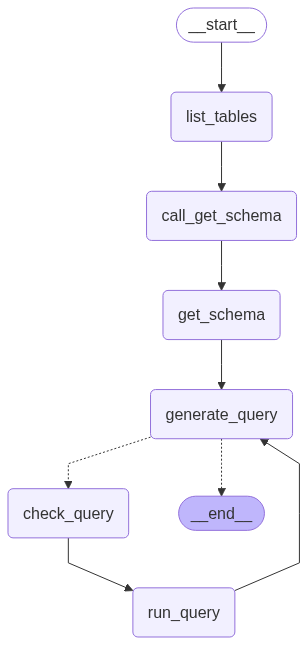

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

We can now invoke the graph exactly as before:

In [9]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_qxKtYiHgf93AiTDin9ez5wFp)
 Call ID: call_qxKtYiHgf93AiTDin9ez5wFp
  Args:
    table_names: Genre,Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Compose

!!! tip

    See [LangSmith trace](https://smith.langchain.com/public/94b8c9ac-12f7-4692-8706-836a1f30f1ea/r) for the above run.

## Next steps

Check out [this guide](https://docs.smith.langchain.com/evaluation/how_to_guides/langgraph) for evaluating LangGraph applications, including SQL agents like this one, using LangSmith.